In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from pandasgui import show

PREFERRED = "Preferred Semantics - Highest cardinality"
GROUNDED = "Grounded Semantics - Highest cardinality"
CATEGORISER = "Categoriser - Highest cardinality"

C:\Users\Work\AppData\Roaming\Python\Python312\site-packages\ipykernel\eventloops.py:128: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [3]:
def int_to_float(df):
    for col in df.columns:
        # Check if the column type is int64
        if df[col].dtype == 'int64':
            # Convert to float64
            df[col] = df[col].astype('float64')

In [4]:
def round_values(df):
    def replace_values(x):

        if np.isnan(x):
            return x

        # If number is not integer, than it is undecided
        if isinstance(x, float) and not x.is_integer():
            return np.nan
        
        return x
    
    df[PREFERRED] = df[PREFERRED].apply(replace_values)
    df[GROUNDED] = df[GROUNDED].apply(replace_values)
    df[CATEGORISER] = df[CATEGORISER].apply(replace_values)

In [5]:
def performance_stats(df, results, df_rulex_test):

    target = "GroundTruth"

    for col in df.columns:
        if col in ["ID", target]:
            continue
        

        valid_indices = df.dropna(subset=[target, col]).index

        # Undecided cases do no enter in the statistics
        # filtered_df = df.dropna(subset=[target, col])
        filtered_df = df.loc[valid_indices]
        filtered_rulex = df_rulex_test.loc[valid_indices]

        # Calculate Kappa score
        kappa = cohen_kappa_score(filtered_df[target], filtered_df[col])

        # Calculate percentage of NAs
        percent_na = 1 - len(filtered_df)/len(df)

        fidelity = (filtered_rulex['pred(target)'] == filtered_df[target]).sum() / len(filtered_df)

        results["Kcohen"].append(kappa)
        results["Percent NA"].append(percent_na)
        results["Fidelity"].append(fidelity)        

In [6]:
def percent_nas(df):
    nan_count = df.isna().sum()

    # Calculate the total number of entries in each column
    total_count = len(df)

    # Calculate the percentage of NaN values in each column
    nan_percentage = (nan_count / total_count) * 100

    # Display the percentage of NaN values
    print("\nPercentage of NaN values in each column:")
    print(nan_percentage)

In [7]:
def unique_values(df, display = False):
    # Initialize a dictionary to store unique values for each column
    unique_values_dict = {}

    # Iterate through each column in the DataFrame
    for col in df.columns:
        if col == "ID":
            continue
        unique_values_dict[col] = df[col].unique()

    if not display:
        return
    
    # Display the unique values for each column
    for col, unique_values in unique_values_dict.items():
        print(f"Unique values in column '{col}': {unique_values}")

In [8]:
def rulex_results(dataset, conditions, error, index_rulex):

    results = {"Kcohen": [], "Percent NA": []}

    rulex_df = pd.read_csv("./rulex_performance.csv")
    rulex_df['Base'] = rulex_df['Base'].str.strip()
    rulex_df['Conditions'] = rulex_df['Conditions'].astype(str).str.strip()
    rulex_df['Error'] = rulex_df['Error'].astype(str).str.strip()

    for e in error:

        filtered_df = rulex_df[(rulex_df['Base'] == dataset) & (rulex_df['Conditions'] == conditions) & (rulex_df['Error'] == e)]
        #print(filtered_df)
        for index, row in filtered_df.iterrows():
            # # Repetition. Can be necessary to compare the same result with multiple others
            # for _ in range(4):
            results["Kcohen"].append(row['Kcohen'])
            results["Percent NA"].append(row['Nas'])

    results_df = pd.DataFrame(results, index=index_rulex)
    return results_df

In [9]:
def get_stats(all_data, bases):

    results_dict = {"# Arguments":[], "# Attacks": [], "Avg Argument Length": [], "# Preferred extensions": [], "# Categoriser ties at top": []}

    for df in all_data:
        for col in df.columns:
            if col == "ID":
                continue
            print()
            results_dict[col].append(df[col].mean())

    budgets = ['25_budget', '50_budget', '90_budget', '100_budget']
    # semantics = ['preferred', 'categoriser', 'grounded']
    row_names = []

    for budget in budgets:
        for base in bases:            
            row_names.append(budget + "_" + base)
    
    results_df = pd.DataFrame(results_dict, index=row_names)

    order = []
    for base in bases:
        for budget in budgets:
            order.append(budget + "_" + base)
    
    return results_df.loc[order]

In [10]:
def get_results_df(all_data, bases, df_rulex_test):
    results_dict = {"Kcohen":[], "Percent NA": [], "Fidelity": []}

    for df in all_data:
        performance_stats(df, results_dict, df_rulex_test)

    budgets = ['25_budget', '50_budget', '90_budget', '100_budget']
    semantics = ['preferred', 'categoriser', 'grounded']
    row_names = []

    for budget in budgets:
        for base in bases:
            for semantic in semantics:
                row_names.append(budget + "_" + base + "_" + semantic)
    
    results_df = pd.DataFrame(results_dict, index=row_names)

    order = []
    for semantic in semantics:
        for base in bases:
            for budget in budgets:
                order.append(budget + "_" + base + "_" + semantic)
    
    return results_df.loc[order]

In [ ]:
# import pandas as pd

# df1 = pd.read_excel('Personality_limited/rulex_results/TestSets_16pers.xlsx', sheet_name=0)

# # Specify the column to ignore
# column_to_ignore = ['Response Id', "Personality", "Personality_TXT", "Row_ID", "Fold", "# of conditions", "pred(target)", "conf(target)"]

# # Get the list of columns to check (all columns except the one to ignore)
# columns_to_check = df1.columns.difference(column_to_ignore)

# # Find duplicated rows ignoring the specified column
# duplicates_ignoring_column = df1[df1.duplicated(subset=columns_to_check, keep=False)]

# #duplicates = df1[df1.duplicated()]
# duplicates_ignoring_column

,Response Id,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q58,Q59,Q60,Personality,Personality_TXT,Row_ID,Fold,# of conditions,pred(target),conf(target)


In [19]:
import pandas as pd

df1 = pd.read_csv('Soccer_limited\soccer_numeric.csv')  # First CSV file

# Specify the column to ignore
column_to_ignore = ["id", 'RESULT']

# Get the list of columns to check (all columns except the one to ignore)
columns_to_check = df1.columns.difference(column_to_ignore)

# Find duplicated rows ignoring the specified column
duplicates_ignoring_column = df1[df1.duplicated(subset=columns_to_check, keep=False)]

#duplicates = df1[df1.duplicated()]
show(duplicates_ignoring_column)

<>:3: SyntaxWarning:

invalid escape sequence '\s'

<>:3: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\3490133450.py:3: SyntaxWarning:

invalid escape sequence '\s'

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
C:\Users\Work\AppData\Local\Temp\ipykernel_8376\3490133450.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\3490133450.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\3490133450.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is dep

In [14]:
import pandas as pd

# Cell to rearrange rulex result files in the correct order
# This is data cleaning for the test results file. Should be moved to the other notebook

# --- Cars ---
# Load the first and second CSV files
# df1 = pd.read_csv('C:/Users/Work/OneDrive - Technological University Dublin/rulex/Multiclass/Cars/cars_numeric.csv')  # First CSV file
# df2 = pd.read_csv('Cars/rulex_results/TestSets_Cars_numeric.csv')

# # Ensure that the rows in df2 match the order of rows in df1 based on common columns

# common = list(df1.columns)
# common.remove("ID")
# common.remove("class")
# print(common)

# df2_sorted = df2.set_index(common).reindex(df1.set_index(common).index).reset_index()

# # Save the reordered second file
# df2_sorted.to_csv('Cars/rulex_results/TestSets_Cars_numeric.csv', index=False)

# --- Myocardial ---
# # Load the first and second CSV files
# df1 = pd.read_csv('Myocardial_limited/myocardial_numeric.csv')  # First CSV file
# df2 = pd.read_excel('Myocardial_limited/rulex_results/TestSets_Myocardio.xlsx', sheet_name=0)

# # Ensure that the rows in df2 match the order of rows in df1 based on common columns
# common = list(df1.columns)
# common.remove("ID")
# # common.remove("class")
# # print(common)

# # print("DF1")
# # print(list(df1.columns))
# # print("DF2")
# # print(list(df2.columns))

# df2_sorted = df2.set_index(common).reindex(df1.set_index(common).index).reset_index()

# # Save the reordered second file
# df2_sorted.to_csv('Myocardial_limited/rulex_results/TestSets_Myocardio_numeric.csv', index=False)


# --- Cirrhosis ---
# # Load the first and second CSV files
# df1 = pd.read_csv('Cirrhosis/cirrhosis_numeric.csv')  # First CSV file
# df2 = pd.read_excel('Cirrhosis/rulex_results/TestSets_Cirrhosis.xlsx', sheet_name=0)

# # Ensure that the rows in df2 match the order of rows in df1 based on common columns

# common = list(df1.columns)
# common.remove("ID")
# common.remove("Stage")
# # print(common)

# df2_sorted = df2.set_index(common).reindex(df1.set_index(common).index).reset_index()

# # Save the reordered second file
# df2_sorted.to_csv('Cirrhosis/rulex_results/TestSets_Cirrhosis_numeric.csv', index=False)

# --- Personality ---
# Load the first and second CSV files
# df1 = pd.read_csv('Personality_limited/16P_numerical2.csv')  # First CSV file
# df2 = pd.read_excel('Personality_limited/rulex_results/TestSets_16pers.xlsx', sheet_name=0)

# # Ensure that the rows in df2 match the order of rows in df1 based on common columns

# common = list(df1.columns)
# common.remove("Personality")
# common.remove("ID")
# # print(common)

# df2_sorted = df2.set_index(common).reindex(df1.set_index(common).index).reset_index()

# # Save the reordered second file
# df2_sorted.to_csv('Personality_limited/rulex_results/TestSets_16pers_numeric.csv', index=False)

# --- Soccer ---
# Load the first and second CSV files
df1 = pd.read_csv('Soccer_limited\soccer_numeric.csv')  # First CSV file
df2 = pd.read_excel('Soccer_limited/rulex_results/TestSets_Soccer.xlsx', sheet_name=0)

# Ensure that the rows in df2 match the order of rows in df1 based on common columns

common = list(df1.columns)
common.remove("RESULT")
common.remove("id")
# print(common)

df2_sorted = df2.set_index(common).reindex(df1.set_index(common).index).reset_index()

# Save the reordered second file
df2_sorted.to_csv('Soccer_limited/rulex_results/TestSets_Soccer_numeric.csv', index=False)


<>:81: SyntaxWarning:

invalid escape sequence '\s'

<>:81: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\2583412361.py:81: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\2583412361.py:81: SyntaxWarning:

invalid escape sequence '\s'



ValueError: cannot handle a non-unique multi-index!

In [7]:
# This is data cleaning for the test results file. Should be moved to the other notebook

# df = pd.read_csv('Personality_limited/rulex_results/TestSets_16pers_numeric.csv')

# mapping = {
#     0: "The Supervisor",
#     1: "The Commander",
#     2: "The Provider",
#     3: "The Giver",
#     4: "The Inspector",
#     5: "The Nurturer",
#     6: "The Mastermind",
#     7: "The Counselor",
#     8: "The Doer",
#     9: "The Performer",
#     10: "The Visionary",
#     11: "The Champion",
#     12: "The Craftsman",
#     13: "The Composer",
#     14: "The Thinker",
#     15: "The Idealist"
# }

# for key, value in mapping.items():     
#     df = df.replace(value, key)  
# df.to_csv('Personality_limited/rulex_results/TestSets_16pers_numeric.csv', index=False)

C:\Users\Work\AppData\Local\Temp\ipykernel_47020\2710938188.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(value, key)


In [13]:
# base = 'myocardial'
# base = 'cars'
# base = 'genetic'
# base = 'cirrhosis'
base = 'personality'

if base == "cars":
    df_rulex_test = pd.read_csv('Cars/rulex_results/TestSets_Cars_numeric.csv')
    error = "_ErrorMax0020Fold1_rules_error_0020"
    bases =  ['20_error']
    limited = ""
if base == "cirrhosis":
    df_rulex_test = pd.read_csv('Cirrhosis/rulex_results/TestSets_Cirrhosis_numeric.csv')
    error = "_ErrorMax0010Fold1_rules_error_0010"
    bases =  ['10_error']
    limited = ""
if base == "myocardial":
    df_rulex_test = pd.read_csv('Myocardial_limited/rulex_results/TestSets_Myocardio_numeric.csv')
    error = "_ErrorMax0010Fold1_rules_error_0010"
    bases =  ['10_error']
    limited = "_limited"
if base == "personality":
    df_rulex_test = pd.read_csv('Personality_limited/rulex_results/TestSets_16pers_numeric.csv')
    error = "_ErrorMax0100Fold1_rules_error_0100"
    bases =  ['10_error']
    limited = "_limited"
if base == "soccer":
    #df_rulex_test = pd.read_csv('Soccer_limited/rulex_results/TestSets_16pers_numeric.csv')
    error = "_soccer_ErrorMax0040Fold1_rules_error_0040"
    bases =  ['04_error']
    limited = "_limited"


root_folder = base.capitalize() + limited + '/results_framework/'

budgets = ['25_budget', '50_budget', '90_budget', '100_budget']

all_data = []
all_data_stats = []

for budget in budgets:
    df = pd.read_csv(root_folder + budget + "/" + base + error + "_" + budget.split("_")[0] + ".csv", na_values='NaN')    
    int_to_float(df)
    round_values(df)
    unique_values(df)
    all_data.append(df)

    df_stats = pd.read_csv(root_folder + budget + "/" + base + error + "_" + budget.split("_")[0] + "_stats.csv", na_values='NaN')
    all_data_stats.append(df_stats)

results_df = get_results_df(all_data, bases, df_rulex_test)
results_df_stats = get_stats(all_data_stats, bases)

show(results_df)
show(results_df_stats)

c:\Users\Work\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:708: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\346414830.py:23: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\Work\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:708: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\346414830.py:23: RuntimeWarning:

invalid value encountered in scalar divide

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
C:\Users\Work\AppData\Local\Temp\ipykernel_8376\2482790248.py:49: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\248

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
C:\Users\Work\AppData\Local\Temp\ipykernel_8376\2482790248.py:50: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\2482790248.py:50: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\2482790248.py:50: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Work\AppData\Local\Temp\ipykernel_8376\2

KeyError: "None of [Index(['AG1', 'AP1', 'AC1', 'H1'], dtype='object')] are in the [index]"

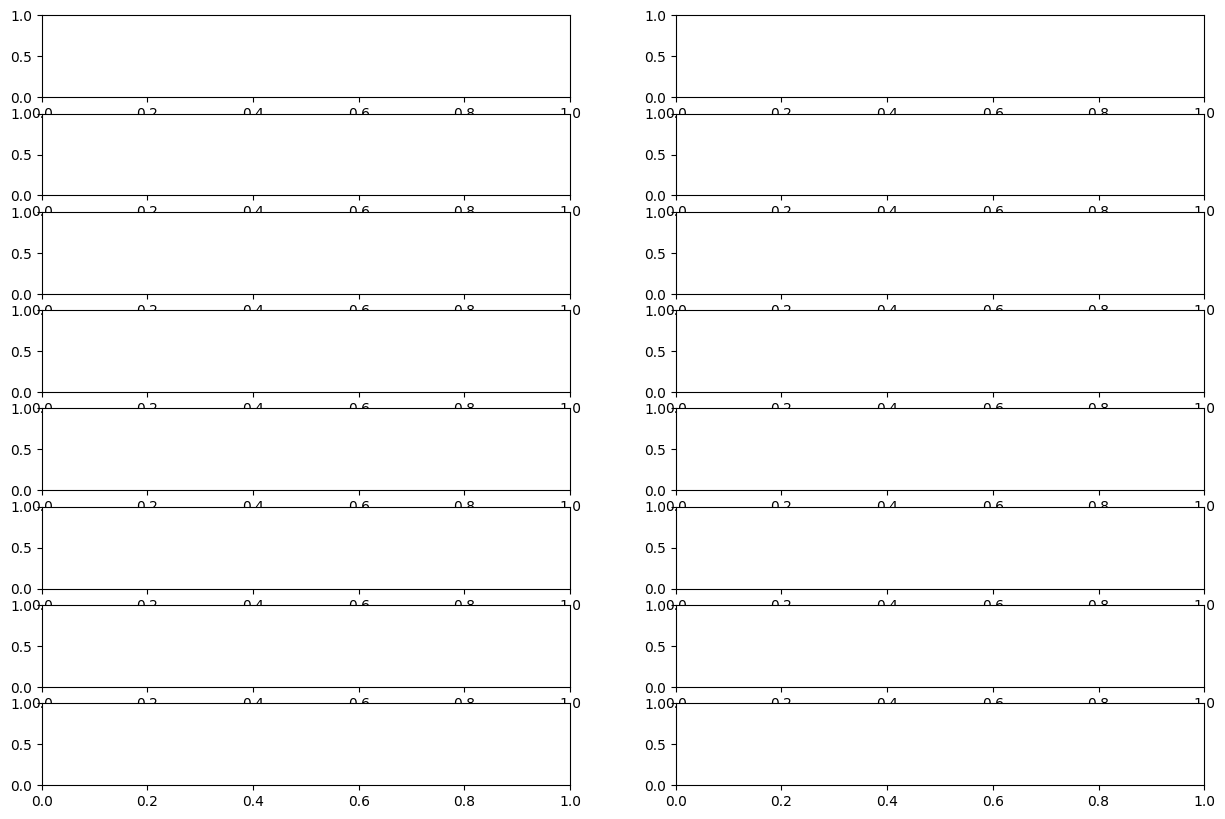

In [12]:
df = results_df

# Define groups
groups = [
    (['AG1', 'AP1', 'AC1', 'H1']),
    (['AG2', 'AP2', 'AC2', 'H1']),
    (['AG3', 'AP3', 'AC3', 'H1']),
    (['AG4', 'AP4', 'AC4', 'H1']),
    (['AG5', 'AP5', 'AC5', 'H2']),
    (['AG6', 'AP6', 'AC6', 'H2']),
    (['AG7', 'AP7', 'AC7', 'H2']),
    (['AG8', 'AP8', 'AC8', 'H2']),
    (['AG9', 'AP9', 'AC9', 'H3']),
    (['AG10', 'AP10', 'AC10', 'H3']),
    (['AG11', 'AP11', 'AC11', 'H3']),
    (['AG12', 'AP12', 'AC12', 'H3']),
    (['AG13', 'AP13', 'AC13', 'H4']),
    (['AG14', 'AP14', 'AC14', 'H4']),
    (['AG15', 'AP15', 'AC15', 'H4']),
    (['AG16', 'AP16', 'AC13', 'H4'])
]

# Create a figure with 16 subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Define colors for each group
colors_group1 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
colors_group2 = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors_group3 = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']
colors_group4 = ['#2c3e50', '#e74c3c', '#27ae60', '#2980b9']

inconsistency_budget = ["25%", "50%", "90%", "100%"] * 4
# error_threshold = ["5%"] * 4 + ["10%"] * 4 + ["15%"] * 4 + ["20%"] * 4
# error_threshold = ["1%"] * 4 + ["4%"] * 4 + ["7%"] * 4 + ["10%"] * 4
error_threshold = ["1%"] * 4 + ["2%"] * 4 + ["3%"] * 4 + ["4%"] * 4

label = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)", "(k)", "(l)", "(m)", "(n)", "(o)", "(p)"]

# Plot each group
for i, group in enumerate(groups):
    group_df = df.loc[group]

    # Transpose the dataframe to have metrics as columns and indexes as rows
    group_df = group_df.T

    # Determine colors for the current group
    if i < 4 :
        colors = colors_group1 
    elif i < 8:
        colors = colors_group2
    elif i < 12:
        colors = colors_group3 
    else:
        colors = colors_group4

    # Plot the grouped bar plot
    ax = group_df.plot(kind='bar', ax=axes[i], width=0.8, alpha=0.7, color=colors)
    axes[i].set_ylabel('Value')
    axes[i].set_ylim(0, 1.2)
    axes[i].set_xticklabels(group_df.index, rotation=0, ha='center')

    # Annotate each bar with its height
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9.5, rotation=45)

    # Set legend for the current subplot (horizontal below the plot)
    handles, labels = ax.get_legend_handles_labels()
    axes[i].text(0.05, 1.17, label[i], transform=axes[i].transAxes, fontsize=10, ha='center', va='center', fontweight='bold')

    axes[i].legend(handles, labels, loc='upper right', bbox_to_anchor=(0.565, 1.3), ncol=len(labels), fontsize='small')
    # Add text below the legend
    axes[i].text(0.76, 1.17, error_threshold[i] + " error threshold per rule, " + inconsistency_budget[i] + " β", transform=axes[i].transAxes, fontsize=10, ha='center', va='center')

plt.tight_layout()

# Adjust vertical space between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.15)

# Adjust layout and save the plot
plt.savefig(base + '.png', dpi=300, bbox_inches='tight')
plt.show()
